In [86]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression, LinearRegression
from catboost import CatBoostClassifier, Pool
%matplotlib inline

In [2]:
data1 = pd.read_csv('formatted_data_fall_2015.csv')
data2 = pd.read_csv('formatted_data_spring_2016.csv')
data3 = pd.read_csv('formatted_data_fall_2016.csv')
data4 = pd.read_csv('formatted_data_spring_2017.csv')
data5 = pd.read_csv('formatted_data_fall_2017.csv')
data6 = pd.read_csv('formatted_data_spring_2018.csv')
data7 = pd.read_csv('formatted_data_fall_2018.csv')

In [3]:
data5 = data5[data5['ITMO']==0]

# EDA

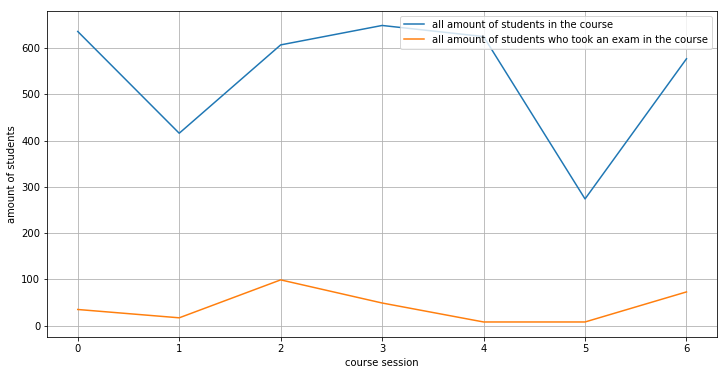

In [4]:
student_amounts = [
    data1.shape[0], data2.shape[0], data3.shape[0], data4.shape[0],
    data5.shape[0], data6.shape[0], data7.shape[0]
]
taken_exam_amount = [
    data1[data1['examinated']==1].shape[0],
    data2[data2['examinated']==1].shape[0],
    data3[data3['examinated']==1].shape[0],
    data4[data4['examinated']==1].shape[0],
    data5[data5['examinated']==1].shape[0],
    data6[data6['examinated']==1].shape[0],
    data7[data7['examinated']==1].shape[0],
]

fig = plt.figure(figsize=(12, 6))
plt.plot(student_amounts, label='all amount of students in the course')
plt.plot(taken_exam_amount, label='all amount of students who took an exam in the course')
plt.grid()
plt.xlabel('course session')
plt.ylabel('amount of students')
plt.legend(loc='upper right')
plt.show();

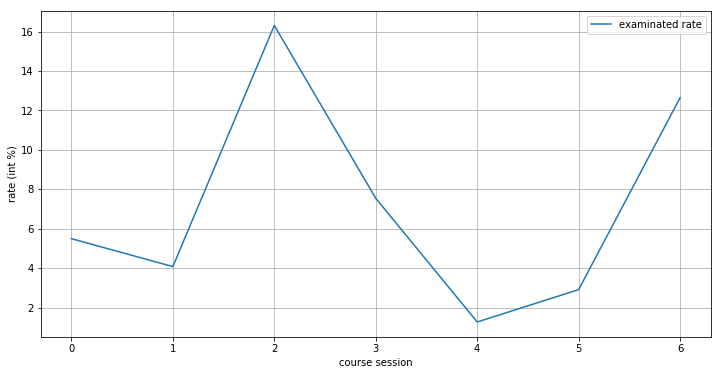

In [166]:
examinated_rate = [
    data1[data1['examinated']==1].shape[0] / data1.shape[0] * 100,
    data2[data2['examinated']==1].shape[0] / data2.shape[0] * 100,
    data3[data3['examinated']==1].shape[0] / data3.shape[0] * 100,
    data4[data4['examinated']==1].shape[0] / data4.shape[0] * 100,  
    data5[data5['examinated']==1].shape[0] / data5.shape[0] * 100,
    data6[data6['examinated']==1].shape[0] / data6.shape[0] * 100,
    data7[data7['examinated']==1].shape[0] / data7.shape[0] * 100,
]
fig = plt.figure(figsize=(12, 6))
plt.plot(examinated_rate, label='examinated rate')
plt.grid()
plt.xlabel('course session')
plt.ylabel('rate (int %)')
plt.legend(loc='upper right')
plt.show();

Let's count the mean of examination rate to use it for a proper threshold

In [167]:
examinated_rate.remove(examinated_rate[2])
exam_rate_mean = np.mean(examinated_rate)

In [6]:
data1['train'] = 1
data2['train'] = 2
data3['train'] = 3
data4['train'] = 4
data5['train'] = 5
data6['train'] = 6
data7['train'] = 7
result = pd.concat([data1, data2, data3, data4, data5, data6, data7], sort=False)
print(result.shape)

(3784, 62)


In [7]:
exam_names = [ 'task_6_amount_of_tries',
 'task_6_durations_max',
 'task_6_durations_mean',
 'task_6_results_max',
 'task_6_results_mean',
 'task_7_amount_of_tries',
 'task_7_durations_max',
 'task_7_durations_mean',
 'task_7_results_max',
 'task_7_results_mean']

result.drop(result[result['ITMO']==1].index, inplace=True)
result.drop('ITMO', axis=1, inplace=True)
result.drop(result['user'].isin(['petric', 'efimchic']), inplace=True)
result.drop(['first_time_action', 'last_time_action', 'grade'], axis=1, inplace=True)
result.drop(exam_names, axis=1, inplace=True)

In [8]:
pd.set_option('display.max_columns', 100)
result.describe()

,max_grade,grade_mean_rate,succes_amount,failure_amount,problems_solved,week_0_video_loads,week_0_activity,week_1_video_loads,week_1_activity,week_2_video_loads,week_2_activity,week_3_video_loads,week_3_activity,week_4_video_loads,week_4_activity,task_0_results_mean,task_0_results_max,task_0_durations_mean,task_0_durations_max,task_0_amount_of_tries,task_1_results_mean,task_1_results_max,task_1_durations_mean,task_1_durations_max,task_1_amount_of_tries,task_2_results_mean,task_2_results_max,task_2_durations_mean,task_2_durations_max,task_2_amount_of_tries,task_3_results_mean,task_3_results_max,task_3_durations_mean,task_3_durations_max,task_3_amount_of_tries,task_4_results_mean,task_4_results_max,task_4_durations_mean,task_4_durations_max,task_4_amount_of_tries,task_5_results_mean,task_5_results_max,task_5_durations_mean,task_5_durations_max,task_5_amount_of_tries,examinated,train
count,3777.000000,3777.000000,3777.000000,3777.000000,3777.000000,3777.000000,3777.000000,3777.000000,3777.000000,3777.000000,3777.000000,3777.000000,3777.000000,3777.000000,3777.000000,737.000000,737.000000,737.000000,737.000000,3777.000000,593.000000,593.000000,593.000000,593.000000,3777.000000,541.000000,541.000000,541.000000,541.000000,3777.000000,517.000000,517.000000,517.000000,517.000000,3777.000000,675.000000,675.000000,675.000000,675.000000,3777.000000,517.000000,517.000000,517.000000,517.000000,3777.000000,3777.000000,3777.000000
mean,5.995499,0.280801,3.921366,2.074133,34.817845,2.644956,6.341276,2.137411,5.652899,2.223458,5.971671,2.221075,6.119936,1.633042,4.727297,64.711588,89.009498,267.099269,768.018159,0.471009,56.330034,86.930860,30.616587,957.456268,0.480275,77.468386,94.103512,510.239230,733.634350,0.253640,79.613830,94.705996,337.520299,512.889007,0.263701,49.491240,80.962963,1189.706351,2631.580296,0.501191,43.113430,80.090909,376.727542,1027.234494,0.469155,0.076251,3.882711
std,10.094848,0.364158,7.205218,4.202162,53.914094,5.150667,12.871113,5.866083,15.311317,7.336448,17.150937,6.917461,18.024353,5.805403,15.444312,34.104234,30.529230,3556.205303,5634.055826,1.245445,27.878096,28.676144,4847.471268,6237.311002,1.366284,29.515187,22.131350,4296.167496,5493.668673,0.797409,25.623768,20.280557,5719.987486,6478.909149,0.848627,33.592744,36.842637,6246.685562,10228.508068,1.385863,29.727677,36.588184,4855.986137,6385.798716,1.515165,0.265434,1.981712
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-47502.791667,0.066667,0.000000,0.000000,0.000000,-76584.153333,0.083333,0.000000,0.000000,0.000000,0.066667,0.066667,0.000000,0.000000,0.000000,-84914.900000,-84914.900000,0.000000,0.000000,0.000000,-42198.777778,0.083333,0.000000,0.000000,0.000000,-70511.875000,0.083333,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.000000,100.000000,2.233333,2.716667,0.000000,38.000000,100.000000,9.046667,12.100000,0.000000,50.000000,100.000000,9.816667,10.500000,0.000000,63.000000,100.000000,7.600000,8.750000,0.000000,25.555556,100.000000,11.818519,16.691667,0.000000,25.000000,100.000000,22.333333,30.866667,0.000000,0.000000,2.000000
50%,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,66.666667,100.000000,3.650000,4.933333,0.000000,55.000000,100.000000,13.202778,19.633333,0.000000,100.000000,100.000000,13.058333,14.283333,0.000000,100.000000,100.000000,10.416667,12.266667,0.000000,46.666667,100.000000,21.033333,29.750000,0.000000,37.500000,100.000000,30.456667,48.000000,0.000000,0.000000,4.000000
75%,8.000000,0.600000,5.000000,3.000000,44.000000,3.000000,4.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,100.000000,7.500000,11.600000,0.000000,75.000000,100.000000,20.183333,32.900000,0.000000,100.0

In [9]:
# delete anomalysis
durations = ['task_{}_durations_mean'.format(i) for i in range(6)]
durations += ['task_{}_durations_max'.format(i) for i in range(6)]
for duration_column in durations:
    result[duration_column] = result[duration_column].apply(lambda i: i if 0<= i <=100 else 0)
result = result.fillna(0)

# generate new features
result['videos_sum'] = [result[['week_{}_video_loads'.format(i) for i in range(5)]][result['user']==user].sum(axis=1).values[0] for user in result['user'].values]
result['activity_sum'] = [result[['week_{}_activity'.format(i) for i in range(5)]][result['user']==user].sum(axis=1).values[0] for user in result['user'].values]
result['mean_attempts'] = [result[['task_{}_amount_of_tries'.format(i) for i in range(6)]][result['user']==user].mean(axis=1).values[0] for user in result['user'].values]
result['mean_score'] = [result[['task_{}_results_mean'.format(i) for i in range(6)]][result['user']==user].mean(axis=1).values[0] for user in result['user'].values]

In [227]:
result.head(10)

,user,max_grade,grade_mean_rate,succes_amount,failure_amount,problems_solved,week_0_video_loads,week_0_activity,week_1_video_loads,week_1_activity,week_2_video_loads,week_2_activity,week_3_video_loads,week_3_activity,week_4_video_loads,week_4_activity,task_0_results_mean,task_0_results_max,task_0_durations_mean,task_0_durations_max,task_0_amount_of_tries,task_1_results_mean,task_1_results_max,task_1_durations_mean,task_1_durations_max,task_1_amount_of_tries,task_2_results_mean,task_2_results_max,task_2_durations_mean,task_2_durations_max,task_2_amount_of_tries,task_3_results_mean,task_3_results_max,task_3_durations_mean,task_3_durations_max,task_3_amount_of_tries,task_4_results_mean,task_4_results_max,task_4_durations_mean,task_4_durations_max,task_4_amount_of_tries,task_5_results_mean,task_5_results_max,task_5_durations_mean,task_5_durations_max,task_5_amount_of_tries,examinated,train,videos_sum,activity_sum,mean_attempts,mean_score
1,id305725842,4.0,0.500000,2,2,20,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,1,0,0,0.000000,0.000000
2,kraplax,2.0,1.000000,2,0,10,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,1,0,0,0.000000,0.000000
3,Muzalika,0.0,0.000000,0,0,4,3,3,0,0,0,0,0,0,0,0,0.0,0.0,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,1,3,3,0.000000,0.000000
4,id73000292,0.0,0.000000,0,0,1,1,1,0,0,0,0,0,0,0,0,0.0,0.0,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,1,1,1,0.000000,0.000000
5,id88035585,1.0,1.000000,1,0,7,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,1,0,0,0.000000,0.000000
6,Aubilith,8.0,1.000000,8,0,35,5,5,0,0,0,0,0,0,0,0,0.0,0.0,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,1,5,5,0.000000,0.000000
7,mrrockpack,3.0,1.000000,3,0,23,5,5,0,0,0,0,0,0,0,0,0.0,0.0,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,1,5,5,0.000000,0.000000
8,id1149997,7.0,0.285714,2,5,28,10,28,0,0,0,0,0,0,0,0,50.0,100.0,1.958333,2.216667,4,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,10.4,10.4,1,0.0,0.0,0.0,0.0,0,0,1,10,28,0.833333,8.333333
9,id4737923,0.0,0.000000,0,0,2,2,2,0,0,0,0,0,0,0,0,0.0,0.0,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,1,2,2,0.000000,0.000000
10,id189312549,0.0,0.000000,0,0,2,2,2,0,0,0,0,0,0,0,0,0.0,0.0,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,1,2,2,0.000000,0.000000


In [10]:
def plot_TSNE(perplexity):
    # plots tsne graph with given perplexity
    # return tsne coordinates
    
    # scale original data
    scaler = StandardScaler().fit(result.fillna(0).drop(['user', 'examinated', 'train'], axis=1))
    data_scaled = pd.DataFrame(scaler.transform(result.fillna(0).drop(['user', 'examinated', 'train'], axis=1)))
    
    # fit tsne with given perplexit
    tsne = TSNE(n_components=2, perplexity=perplexity)
    tsne_results = tsne.fit_transform(data_scaled)
    
    # plot the results
    fig = plt.figure(figsize=(12, 10))
    plt.title('t-SNE with perplexity {}'.format(perplexity))
    plt.scatter(tsne_results[result['examinated']==1, 0], tsne_results[result['examinated']==1, 1],
               label='examinated', alpha=0.9, color='orange')
    plt.scatter(tsne_results[result['examinated']==0, 0], tsne_results[result['examinated']==0, 1],
               label='not examinated', alpha=0.5, color='royalblue')

    plt.grid()
    plt.legend();
    return tsne_results

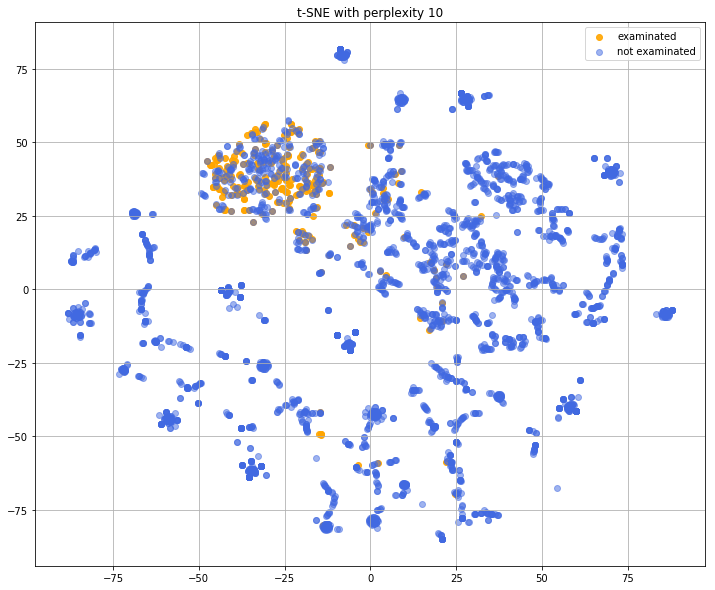

In [13]:
plot_TSNE(10);

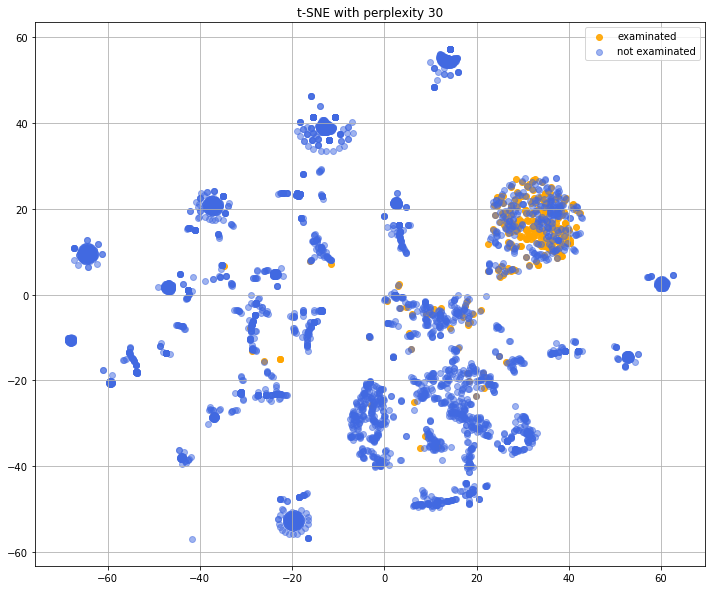

In [18]:
tsne_features = plot_TSNE(30);

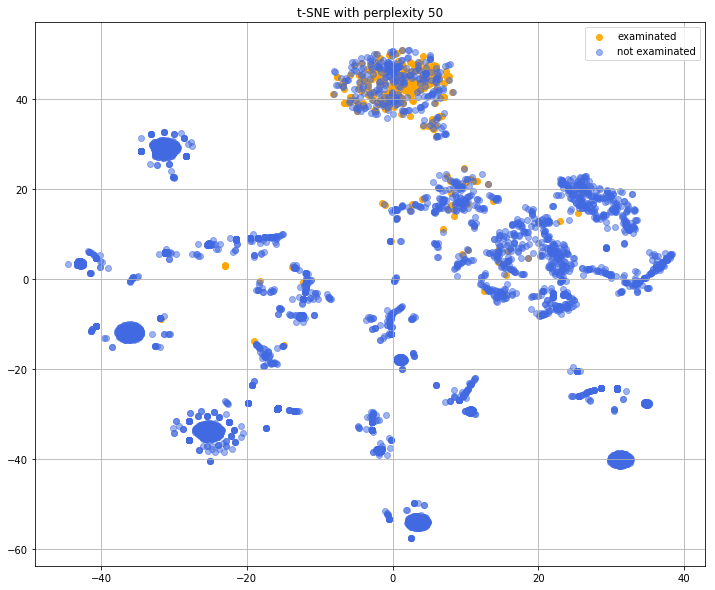

In [15]:
plot_TSNE(50);

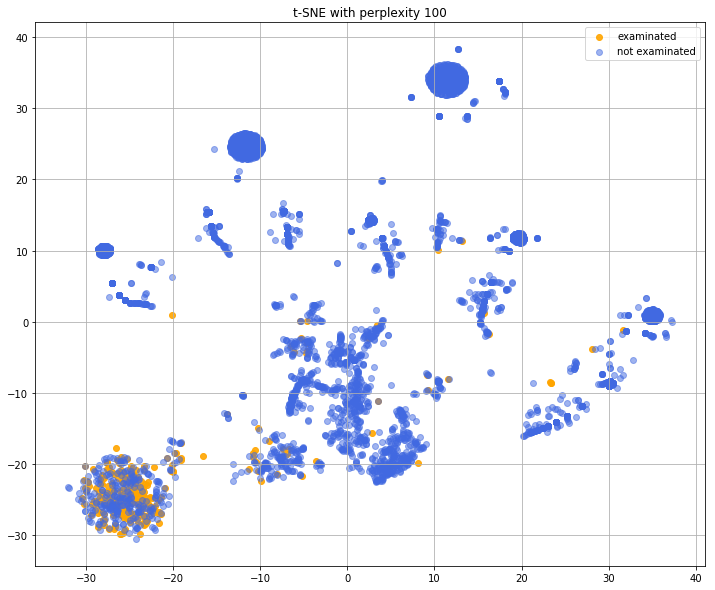

In [16]:
plot_TSNE(100);

### video loads activity

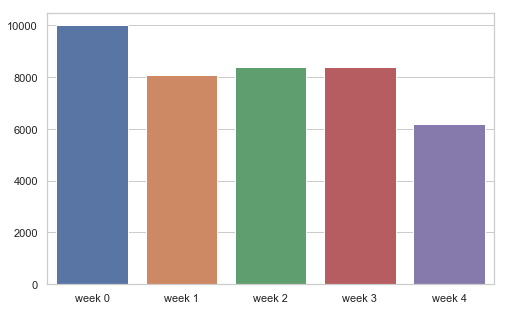

In [17]:
video_loads_activity = result[['week_{}_video_loads'.format(i) for i in range(5)]].sum()
fig = plt.figure(figsize=(8,5))
sns.set(style="whitegrid")
sns.barplot(x=['week {}'.format(i) for i in range(5)], y=video_loads_activity);

### general activity

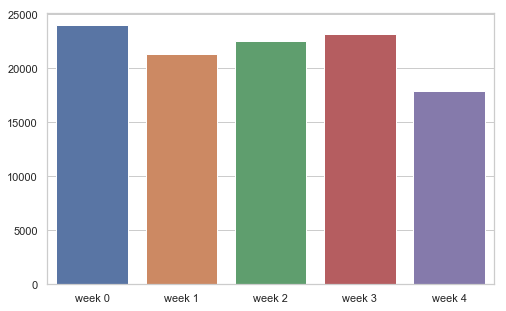

In [18]:
video_loads_activity = result[['week_{}_activity'.format(i) for i in range(5)]].sum()
fig = plt.figure(figsize=(8,5))
sns.set(style="whitegrid")
sns.barplot(x=['week {}'.format(i) for i in range(5)], y=video_loads_activity);

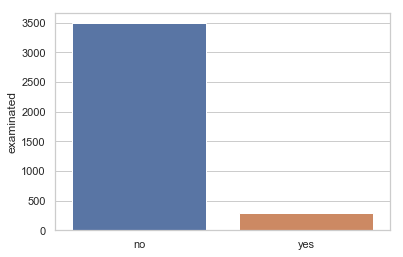

In [19]:
sns.barplot(x=['no', 'yes'], y=result['examinated'].value_counts());

In [20]:
static_features = [
    'videos_sum', 'activity_sum', 'max_grade', 'grade_mean_rate', 'succes_amount',
       'failure_amount', 'mean_attempts', 'mean_score', 'problems_solved', 'examinated', 
]

time_features = [
    'task_0_results_mean', 'task_1_results_mean', 'task_2_results_mean', 'task_3_results_mean', 'task_4_results_mean', 'task_5_results_mean',
    'task_0_amount_of_tries', 'task_1_amount_of_tries', 'task_2_amount_of_tries', 'task_3_amount_of_tries', 'task_4_amount_of_tries', 'task_5_amount_of_tries',
    'examinated'
]

## Pearson correlations

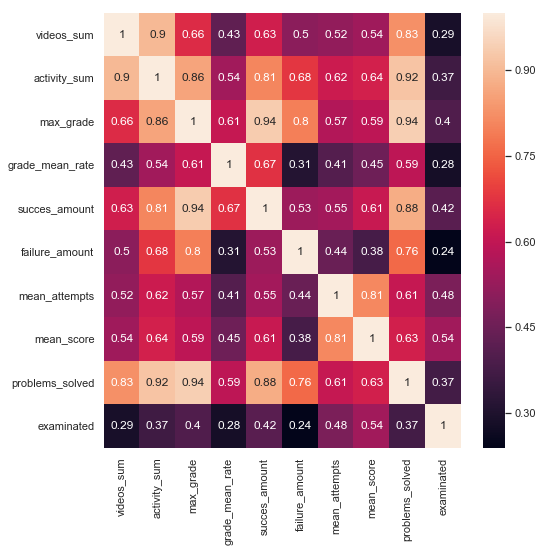

In [21]:
fig = plt.figure(figsize=(8,8))
sns.heatmap(result[static_features].corr(), annot=True);

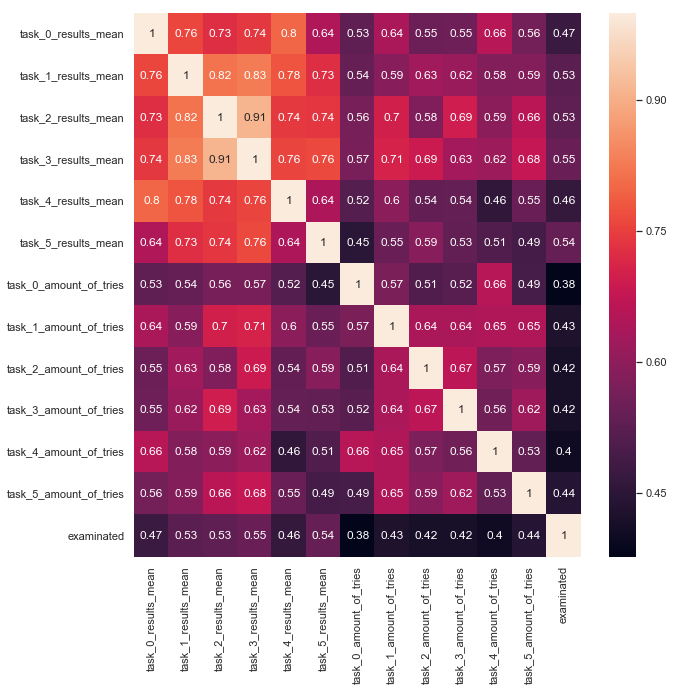

In [22]:
fig = plt.figure(figsize=(10,10))
sns.heatmap(result[time_features].corr(), annot=True);

## Spearman correlations

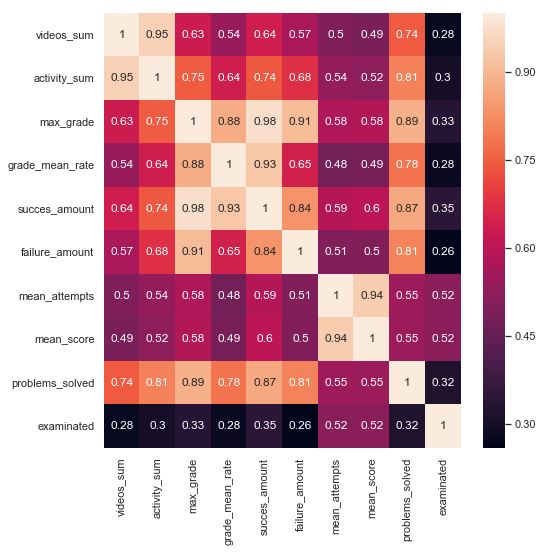

In [23]:
fig = plt.figure(figsize=(8,8))
sns.heatmap(result[static_features].corr('spearman'), annot=True);

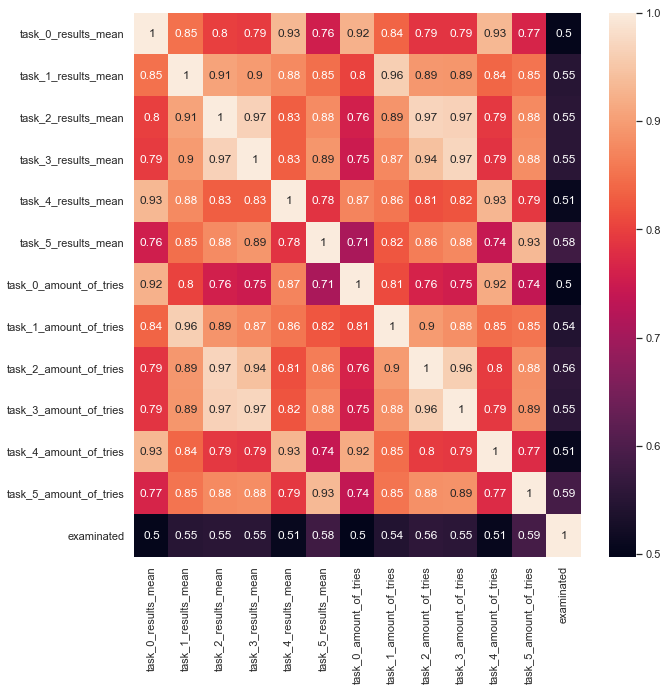

In [24]:
fig = plt.figure(figsize=(10,10))
sns.heatmap(result[time_features].corr('spearman'), annot=True);

# Fitting

Let's define CV of K folds in respect to sessions

In [12]:
def log_reg_cross_validation(data, splits=[1,2,3,4,5,6]):
    model = LogisticRegression(random_state=42)
    results = []
    
    for split in splits:
        X_train = data[data['train']!=split].drop(['examinated', 'train', 'user'], axis=1)
        X_test = data[data['train']==split].drop(['examinated', 'train', 'user'], axis=1)
        y_train = data[data['train']!=split]['examinated']
        y_test = data[data['train']==split]['examinated']
        
        model.fit(X_train.values, y_train)
        pred_probas = model.predict_proba(X_test.values)[:, 1]
        results.append(roc_auc_score(y_test, pred_probas))
        print('split {} done'.format(split))
        
    return results
    
    
def cat_boost_cross_validation(data, splits=[1,2,3,4,5,6]):
    model = CatBoostClassifier(random_state=42, max_depth=8)
    results = []
    
    for split in splits:
        X_train = data[data['train']!=split].drop(['examinated', 'train', 'user'], axis=1)
        X_test = data[data['train']==split].drop(['examinated', 'train', 'user'], axis=1)
        y_train = data[data['train']!=split]['examinated']
        y_test = data[data['train']==split]['examinated']
        
        model.fit(X_train, y_train, eval_set=(X_test, y_test), silent=True, 
                    use_best_model=True, early_stopping_rounds=150)
        pred_probas = model.predict_proba(X_test)[:, 1]
        results.append(roc_auc_score(y_test, pred_probas))
        print('split {} done'.format(split))
        
    return results

def log_reg_valid_prediction(data, split=6):
    model = LogisticRegression(random_state=42)
    
    X_train = data[data['train']!=split].drop(['examinated', 'train', 'user'], axis=1)
    X_test = data[data['train']==split].drop(['examinated', 'train', 'user'], axis=1)
    y_train = data[data['train']!=split]['examinated']
    y_test = data[data['train']==split]['examinated']
    model.fit(X_train, y_train)
    pred_probas = model.predict_proba(X_test.values)[:, 1]
    print('roc auc: {}'.format(roc_auc_score(y_test, pred_probas)))
    return pred_probas
    
def cat_boost_valid_prediction(data, split=6):
    model = CatBoostClassifier(random_state=42)
    
    X_train = data[data['train']!=split].drop(['examinated', 'train', 'user'], axis=1)
    X_test = data[data['train']==split].drop(['examinated', 'train', 'user'], axis=1)
    y_train = data[data['train']!=split]['examinated']
    y_test = data[data['train']==split]['examinated']
    model.fit(X_train, y_train, eval_set=(X_test, y_test), silent=True, 
            use_best_model=True, early_stopping_rounds=150)
    pred_probas = model.predict_proba(X_test)[:, 1]
    print('roc auc: {}'.format(roc_auc_score(y_test, pred_probas)))
    return pred_probas

### Cross-validation

In [13]:
lg_results = log_reg_cross_validation(result[result['train']!=7])
print()
cat_results = cat_boost_cross_validation(result[result['train']!=7])

print('mean lg: {} +- {}'.format(round(np.mean(lg_results), 5), round(np.std(lg_results), 4)))
print('mean cat: {} +- {}'.format(round(np.mean(cat_results), 5), round(np.std(cat_results), 4)))

split 1 done
split 2 done
split 3 done
split 4 done
split 5 done
split 6 done

Learning rate set to 0.086144
split 1 done
Learning rate set to 0.086891
split 2 done
Learning rate set to 0.086245
split 3 done
Learning rate set to 0.086098
split 4 done
Learning rate set to 0.086182
split 5 done
Learning rate set to 0.087346
split 6 done
mean lg: 0.88699 +- 0.0274
mean cat: 0.93151 +- 0.0396


## Predictions on validation set

In [27]:
def compare_predictions(split=6):
    print('Logistic regression')
    lg_preds = log_reg_valid_prediction(result[result['train']!=7], split)
    print('Cat boost')
    cat_preds = cat_boost_valid_prediction(result[result['train']!=7], split)

    fig = plt.figure(figsize=(7, 7))
    plt.scatter(lg_preds[result[(result['train']==split) & (result['examinated']==0)].index - 1],
                         cat_preds[result[(result['train']==split) & (result['examinated']==0)].index - 1], label='not examinated')
    plt.scatter(lg_preds[result[(result['train']==split) & (result['examinated']==1)].index - 1],
                         cat_preds[result[(result['train']==split) & (result['examinated']==1)].index - 1], label='examinated')
    plt.plot([0, 1], [0, 1], alpha=0.4, label='prediction simularity line')
    plt.xlabel('LG preds')
    plt.ylabel('cat preds')
    plt.legend()
    plt.show();

Logistic regression
roc auc: 0.9082857142857141
Cat boost
Learning rate set to 0.086144
roc auc: 0.9759761904761906


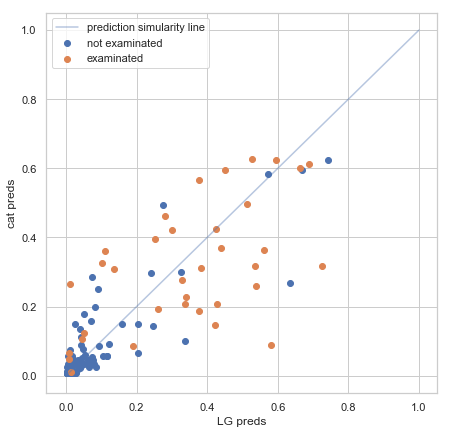

In [28]:
compare_predictions(1)

Logistic regression
roc auc: 0.8724504877327817
Cat boost
Learning rate set to 0.086891
roc auc: 0.9300916346438073


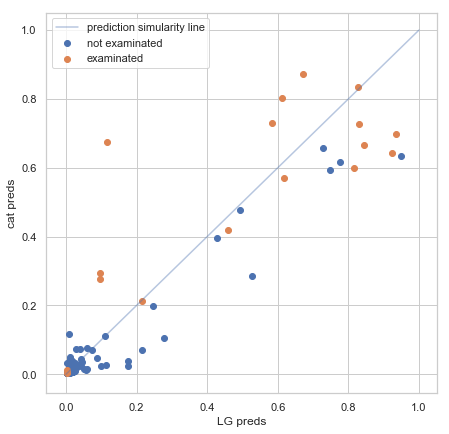

In [29]:
compare_predictions(2)

Logistic regression
roc auc: 0.9037441748352885
Cat boost
Learning rate set to 0.086245
roc auc: 0.9394484171621406


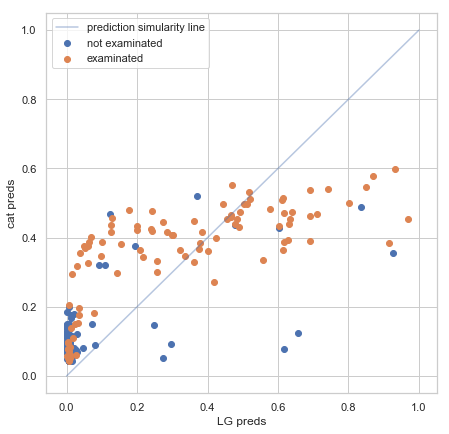

In [30]:
compare_predictions(3)

Logistic regression
roc auc: 0.843480630983612
Cat boost
Learning rate set to 0.086098
roc auc: 0.972368914176689


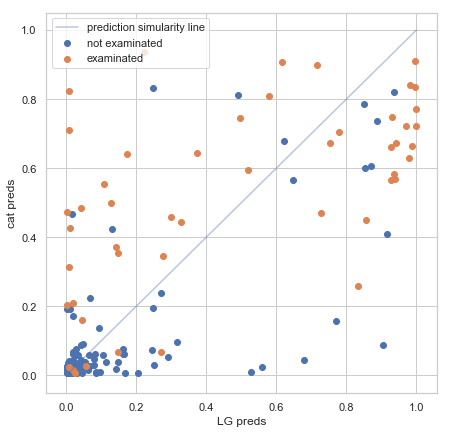

In [31]:
compare_predictions(4)

The predictions are located in different areas of simularity line. It makes sense to create some kind of conditional ensemble of these models. We will try stacking scheme

# Applying stacking

Data3 set seems the most appropriate for stacking because of the amount of target data and variance of predictions of different models. Let's use it as a validation set for stacking LG and CatBoost models

In [231]:
def stacking_with_validation(data, valid_split=3, test_split=7):
    # perfoms stacking via validation set
    # return (X_valid_level2, y_valid_level2, X_test_level2, lg, cat1, cat2)
    X_train = data[(data['train']!=valid_split) & (data['train']!=test_split)].drop(['examinated', 'train', 'user'], axis=1)
    X_valid = data[data['train']==valid_split].drop(['examinated', 'train', 'user'], axis=1)
    X_test = data[data['train']==test_split].drop(['examinated', 'train', 'user'], axis=1)

    y_train = data[(data['train']!=valid_split) & (data['train']!=test_split)]['examinated']
    y_valid = data[data['train']==valid_split]['examinated']
    y_test = data[data['train']==test_split]['examinated']
    
    lg = LogisticRegression(random_state=42)
    cat1 = CatBoostClassifier(random_state=42, max_depth=5)
    cat2 = CatBoostClassifier(random_state=42, max_depth=8)
    
    X_valid_level2 = np.zeros((X_valid.shape[0], 3))
    X_test_level2 = np.zeros((X_test.shape[0], 3))
    y_valid_level2 = np.zeros((X_valid.shape[0], ))
    
    # predictions on validation set
    lg.fit(X_train.values, y_train)
    cat1.fit(X_train, y_train, eval_set=(X_valid, y_valid), silent=True, 
        use_best_model=True, early_stopping_rounds=150)
    cat2.fit(X_train, y_train, eval_set=(X_valid, y_valid), silent=True, 
        use_best_model=True, early_stopping_rounds=150)
    lg_preds = lg.predict_proba(X_valid.values)[:, 1]
    cat_preds1 = cat1.predict_proba(X_valid.values)[:, 1]
    cat_preds2 = cat2.predict_proba(X_valid.values)[:, 1]
    
    X_valid_level2[:, 0] = lg_preds
    X_valid_level2[:, 1] = cat_preds1
    X_valid_level2[:, 2] = cat_preds2
    y_valid_level2[:] = y_valid
    
    lg_preds = lg.predict_proba(X_test.values)[:, 1]
    cat_preds1 = cat1.predict_proba(X_test.values)[:, 1]
    cat_preds2 = cat1.predict_proba(X_test.values)[:, 1]
    
    X_test_level2[:, 0] = lg_preds
    X_test_level2[:, 1] = cat_preds1
    X_test_level2[:, 2] = cat_preds2
    
    return(X_valid_level2, y_valid_level2, X_test_level2, lg, cat1, cat2)



def perfome_meta_model(X_train, y_train, X_test):
    # performs meta model (logistic regression) on n-dimensional dataset 
    # return (final_probabilities, meta_model)
    meta_model = LogisticRegression(random_state=42)
    meta_model.fit(X_train, y_train)
    final_probas = meta_model.predict_proba(X_test)[:, 1]
    return (final_probas, meta_model)

def compare_models(val_set=3):
    
    cat_res = []
    lg_res = []
    stack_res = []
    
    for split in range(1, 8):
        if split != val_set:
            print('test set: {}'.format(split))
            cat = CatBoostClassifier(random_state=42, silent=True)
            cat.fit(result[result['train']!=split].drop(['examinated', 'user', 'train'], axis=1), result[result['train']!=split]['examinated'])
            cat_preds = cat.predict_proba(result[result['train']==split].drop(['examinated', 'user', 'train'], axis=1))[:, 1]
            print('ROC AUC with cat: {}'.format(roc_auc_score(result[result['train']==split]['examinated'], cat_preds)))
            cat_res.append(roc_auc_score(result[result['train']==split]['examinated'], cat_preds))

            lg = LogisticRegression(random_state=42)
            lg.fit(result[result['train']!=split].drop(['examinated', 'user', 'train'], axis=1), result[result['train']!=split]['examinated'])
            lg_preds = lg.predict_proba(result[result['train']==split].drop(['examinated', 'user', 'train'], axis=1))[:, 1]
            print('ROC AUC with lg: {}'.format(roc_auc_score(result[result['train']==split]['examinated'], lg_preds)))
            lg_res.append(roc_auc_score(result[result['train']==split]['examinated'], lg_preds))

            X_valid_level2, y_valid_level2, X_test_level2, _, _, _ = stacking_with_validation(result, test_split=split)
            final_probas, _ = perfome_meta_model(X_valid_level2, y_valid_level2, X_test_level2)
            print('ROC AUC after stacking: {}'.format(roc_auc_score(result[result['train']==split]['examinated'], final_probas)))
            stack_res.append(roc_auc_score(result[result['train']==split]['examinated'], final_probas))
            print()
    print('lg mean: {} +- {}'.format(np.mean(lg_res), np.std(lg_res)))
    print('cat mean: {} +- {}'.format(np.mean(cat_res), np.std(cat_res)))
    print('stacking mean: {} +- {}'.format(np.mean(stack_res), np.std(stack_res)))

Let's compare stacking results with single models

In [232]:
compare_models()

test set: 1
Learning rate set to 0.023165
ROC AUC with cat: 0.9545714285714286
ROC AUC with lg: 0.9254761904761905
Learning rate set to 0.086037
Learning rate set to 0.086037
ROC AUC after stacking: 0.9767142857142856

test set: 2
Learning rate set to 0.023613
ROC AUC with cat: 0.9302394324563996
ROC AUC with lg: 0.8702335205438959
Learning rate set to 0.086792
Learning rate set to 0.086792
ROC AUC after stacking: 0.9688146615430092

test set: 4
Learning rate set to 0.023138
ROC AUC with cat: 0.9780245988211647
ROC AUC with lg: 0.9115532690538654
Learning rate set to 0.085991
Learning rate set to 0.085991
ROC AUC after stacking: 0.9742087152056148

test set: 5
Learning rate set to 0.023188
ROC AUC with cat: 0.9117288961038961
ROC AUC with lg: 0.7658279220779223
Learning rate set to 0.086076
Learning rate set to 0.086076
ROC AUC after stacking: 0.8875811688311688

test set: 6
Learning rate set to 0.023891
ROC AUC with cat: 0.8924528301886793
ROC AUC with lg: 0.8650943396226415
Learning 

## Performing stacking

In [216]:
%%time
# a session we want to as a test set
test_split = 1

X_valid_level2, y_valid_level2, X_test_level2, lg, cat1, cat2 = stacking_with_validation(result, test_split=test_split)
final_probas, meta_model = perfome_meta_model(X_valid_level2, y_valid_level2, X_test_level2)
y_test = result[result['train']==test_split]['examinated']

print('ROC AUC with stacking (test): {}'.format(roc_auc_score(y_test, final_probas)))

Learning rate set to 0.086037
Learning rate set to 0.086037
ROC AUC with stacking (test): 0.9767142857142856
Wall time: 20.5 s


### Final ROC curve

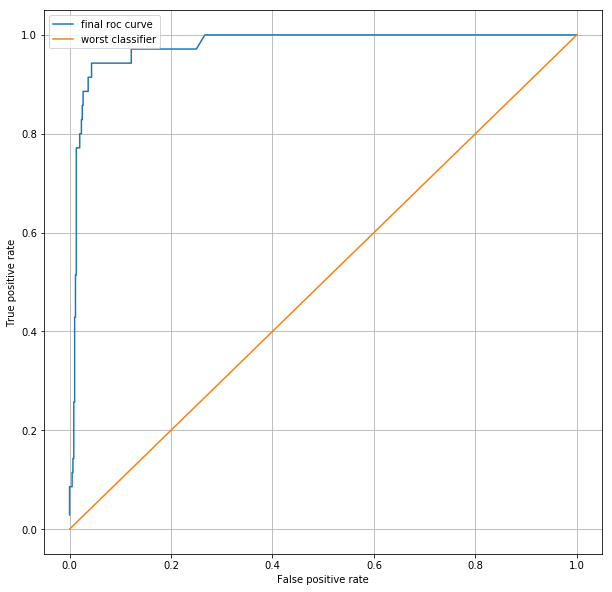

In [217]:
fpr, tpr, thresholds = roc_curve(y_test, final_probas)
fig = plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, label='final roc curve')
plt.plot([0, 1], [0, 1], label='worst classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.grid()
plt.legend();

### Feature importance 

In [219]:
cat_feature_importance1 = pd.DataFrame({'feature' : result.drop(['examinated', 'user', 'train'], axis=1).columns,
                            'importance in %' : cat1.feature_importances_})
cat_feature_importance1.sort_values('importance in %', ascending=False).iloc[:10]

,feature,importance in %
46,activity_sum,18.377669
8,week_1_activity,10.423771
24,task_1_amount_of_tries,5.462941
44,task_5_amount_of_tries,5.278685
47,mean_attempts,5.169218
41,task_5_results_max,4.920421
42,task_5_durations_mean,4.103902
40,task_5_results_mean,4.048704
13,week_4_video_loads,3.999981
1,grade_mean_rate,3.978529


In [220]:
cat_feature_importance2 = pd.DataFrame({'feature' : result.drop(['examinated', 'user', 'train'], axis=1).columns,
                            'importance in %' : cat2.feature_importances_})
cat_feature_importance2.sort_values('importance in %', ascending=False).iloc[:10]

,feature,importance in %
4,problems_solved,12.935772
6,week_0_activity,11.459787
8,week_1_activity,11.276064
44,task_5_amount_of_tries,6.675769
13,week_4_video_loads,4.096885
3,failure_amount,4.075219
17,task_0_durations_mean,3.542993
1,grade_mean_rate,3.483281
5,week_0_video_loads,3.244581
7,week_1_video_loads,3.231354


Scale lg features in percentage

In [221]:
lg_features_importance = abs(lg.coef_[0])
scaler = MinMaxScaler(feature_range=(0, 20.161))
lg_feature_importance_scaled = scaler.fit_transform(lg_features_importance.reshape((-1, 1)))

lg_feature_importance = pd.DataFrame({'feature' : result.drop(['examinated', 'user', 'train'], axis=1).columns,
                            'importance in %' : lg_feature_importance_scaled[:, 0]})
lg_feature_importance.sort_values('importance in %', ascending=False).iloc[:10]

,feature,importance in %
47,mean_attempts,20.161000
34,task_3_amount_of_tries,11.938937
1,grade_mean_rate,11.886239
19,task_0_amount_of_tries,6.320748
44,task_5_amount_of_tries,4.611135
0,max_grade,3.171429
24,task_1_amount_of_tries,2.990314
29,task_2_amount_of_tries,2.491041
39,task_4_amount_of_tries,2.241086
2,succes_amount,1.807560


### Final feature importance

Let's count feature importance of models in respect to meta model feature importance

In [222]:
lg_importance, cat1_importance, cat2_importance = meta_model.coef_[0] / 10
final_importance = cat1_importance*cat1.feature_importances_ + cat2_importance*cat2.feature_importances_ + lg_importance*lg_feature_importance_scaled[:, 0]
final_feature_importance = pd.DataFrame({'feature' : result.drop(['examinated', 'user', 'train'], axis=1).columns,
                            'importance in %' : final_importance})
final_feature_importance.sort_values('importance in %', ascending=False).iloc[:10]

,feature,importance in %
8,week_1_activity,8.809242
47,mean_attempts,8.399919
46,activity_sum,8.152723
6,week_0_activity,6.282140
1,grade_mean_rate,6.100860
44,task_5_amount_of_tries,6.004920
4,problems_solved,5.284185
34,task_3_amount_of_tries,3.445132
13,week_4_video_loads,3.287031
41,task_5_results_max,3.245092


# Applying the final model

#### Predict the most succesful users

In [225]:
test_users = result[result['train']==test_split]['user']
test_examination = result[result['train']==test_split]['examinated']
pred_data = pd.DataFrame({'user' : test_users, 'proba' : final_probas, 'examinated' : test_examination})
sorted_preds = pred_data.sort_values('proba', ascending=False)
sorted_preds.head(20)

,user,proba,examinated
54,192803,0.866112,1
368,idbisdance,0.861555,1
505,kirillradyg,0.854212,1
547,id269328952,0.822057,0
445,aleksandrkalinin,0.821678,0
565,vadimmalykh,0.816230,0
517,shappiron,0.803782,1
297,k5p5o5,0.776488,0
424,dashka_autumn,0.771888,1
61,nazarova_marija,0.766567,0


#### Predict the target group

In [226]:
expected_value_of_examinations = int(exam_rate_mean * test_users.shape[0] / 100)
sorted_preds.iloc[expected_value_of_examinations:].head(20)

,user,proba,examinated
40,natalie_green,0.474121,0
401,paru4ik,0.445327,0
146,vvuri,0.435234,0
92,mmattheww,0.423205,0
377,olegkuznetsov,0.421633,1
163,id69585168,0.416349,0
194,aleksey_martynyuk,0.401545,0
159,gapel,0.379259,1
522,larin13,0.377070,0
579,eugeniu89,0.334836,1
